<a href="https://colab.research.google.com/github/yesp2002/Live-Stock-Prediction/blob/main/Live_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#yahoo finance as data source
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 31.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [4]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-02,135.365692,136.054749,133.734436,134.001633,112.472038,10743390
2017-02-03,134.156311,135.421936,132.257874,134.634445,113.003204,7316433
2017-02-06,134.915695,136.265686,134.296936,135.689133,113.888428,6681287
2017-02-07,136.406311,137.995377,132.904755,133.931320,112.413033,8439722
2017-02-08,134.184448,137.109436,133.593811,136.504761,114.573006,3663756


In [7]:
len(data)

1236

In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-27,142.000000,144.050003,140.949997,141.300003,141.300003,12310614
2022-01-28,142.149994,146.199997,141.300003,141.800003,141.800003,8927075
2022-01-31,143.000000,144.949997,142.449997,144.300003,144.300003,5185472
2022-02-01,145.000000,148.000000,144.149994,147.500000,147.500000,10241254
2022-02-02,148.500000,148.750000,146.500000,146.649994,146.649994,2095198


In [9]:
opn = data[['Open']]

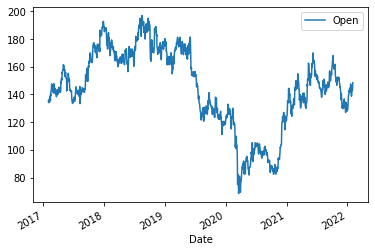

In [10]:
opn.plot()

In [11]:
import matplotlib.pyplot as plt

In [12]:
ds = opn.values

In [13]:
ds

array([[135.36569214],
       [134.15631104],
       [134.91569519],
       ...,
       [143.        ],
       [145.        ],
       [148.5       ]])

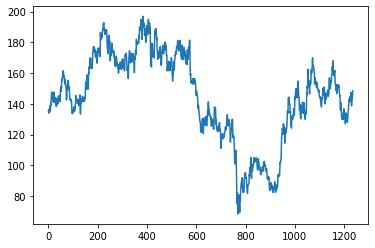

In [14]:
plt.plot(ds)

In [15]:
import numpy as np

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [18]:
len(ds_scaled), len(ds)

(1236, 1236)

In [19]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [20]:
train_size,test_size

(865, 371)

In [21]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [22]:
len(ds_train),len(ds_test)

(865, 371)

In [23]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [24]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [25]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [26]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [27]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [29]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 10s 380ms/step - loss: 0.1231 - val_loss: 0.0083
Epoch 2/100
12/12 [==============================] - 4s 316ms/step - loss: 0.0209 - val_loss: 0.0160
Epoch 3/100
12/12 [==============================] - 2s 200ms/step - loss: 0.0112 - val_loss: 0.0038
Epoch 4/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 5/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 6/100
12/12 [==============================] - 2s 200ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/100
12/12 [==============================] - 2s 202ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/100
12/12 [==============================] - 2s 202ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0035 - val_l

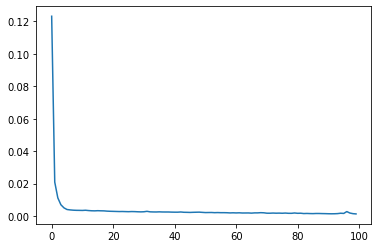

In [31]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [32]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [33]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

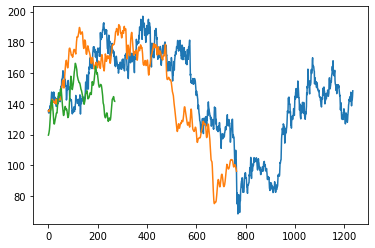

In [34]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [35]:
type(train_predict)

numpy.ndarray

In [41]:
test = np.vstack((train_predict,test_predict))
#test = np.vstack((ds[:100],test))

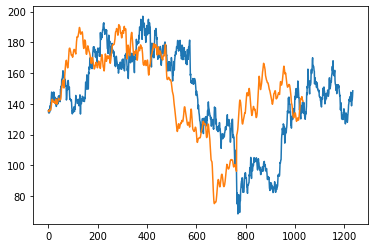

In [42]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [43]:
len(ds_test)

371

In [44]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [45]:
fut_inp = fut_inp.reshape(1,-1)

In [46]:
tmp_inp = list(fut_inp)

In [47]:
fut_inp.shape

(1, 101)

In [48]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [49]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.5864077210426331], [0.5928774476051331], [0.5961953401565552], [0.5978896021842957], [0.5987918376922607], [0.599309504032135], [0.5996293425559998], [0.599838376045227], [0.5999833345413208], [0.6000939011573792], [0.600193440914154], [0.6002984046936035], [0.6004211902618408], [0.6005696654319763], [0.6007475256919861], [0.6009550094604492], [0.6011906862258911], [0.6014508605003357], [0.6017310619354248], [0.6020265221595764], [0.6023328304290771], [0.6026455163955688], [0.6029611825942993], [0.6032770872116089], [0.6035912036895752], [0.6039025783538818], [0.6042101979255676], [0.6045147180557251], [0.6048162579536438], [0.6051154732704163]]


In [50]:
len(ds_scaled)

1236

In [51]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

ValueError: ignored

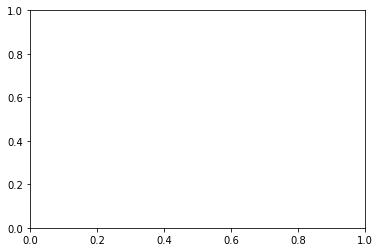

In [52]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1232

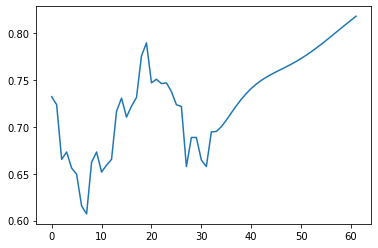

In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

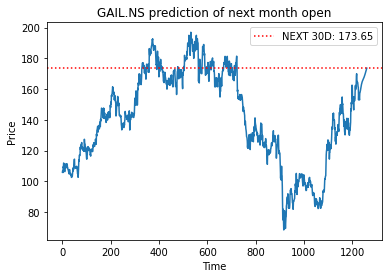

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

